# Unsupervised Algorithms in Machine Learning - Final Project
## AI Generated Text Detector


**Github link** https://github.com/conditas/MachineLearning/tree/AI_detect


In only a few years, large language models have become a tool with great potential, spanning a variety of applications. However, one of the biggest areas of concern with LLM is in academics. Concerns include plagarism, dimishing skill developemnt in students and spread of misinformation. Being able to accurately detect AI generated content from human generated content will be increasingly more important with advances in this technology.    

In my research I was able to find solutions using advanced deep learning algorithms, however in this project I am testing approaches using the unsupervised learning algorithms explored in our class. I will use prediction accuracy as the performance metric. I will model two unsupervised machine learning algorithms: one class support vector machine and non-negative matrix factorization using Kullback-Leibler divergence. I will then compare the preformance to two supervised machine learning algorithms: Logistic Regression and Linear SVC.

### Import Libraries

The following libraries will be used in my project.

In [10]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
import umap 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from itertools import permutations 
from sklearn.svm import OneClassSVM 
    




### Load Data

The data I am using is in the form of a .csv file with id, text and generate columns. In the generated column '0' indicates human produced content and '1' indicates AI produced content. The initial dataset had 29145 rows.

|Feature Summary |	|
|:---------|:-------------|
|id 	|unique index|
|text |	Text of the essay|
|generated |	1- AI; 0- Human|

Using a 80/20 split, I broke the data into training and testing datasets. I also split out the generated column into a separate data frame to use for accuracy prediction. 

**Data Source Citation:** 

Sunil Thite. (2023). LLM - Detect AI Generated Text Dataset, Version 1. Kaggle.com. Retrieved September 10, 2024 from https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data

In [11]:
df = pd.read_csv('Training_Essay_Data.csv')
print("Original Length: ", len(df))


X = df.drop('generated', axis=1)
y = df['generated'] # target variable

X_train, X_test, y_train, y_test  = train_test_split(X,y, 
                                   random_state=1234,  
                                   test_size=0.2,  
                                   shuffle=True) 


print(df.dtypes)


print("\nTrain Length: ", len(X_train))
print("Test Length: ", len(X_test))



Original Length:  29145
text         object
generated     int64
dtype: object

Train Length:  23316
Test Length:  5829


### Clean Data

In order to clean the dataset for modeling, I first double check for any null or duplicate values in the text column. Since the human generated count was about fifty percent higher than the AI count, I rebalance the training dataset. 

Next I preprocess the text to remove "stop" words and also reduce words to their stems. This helps to filter out the text for content and essence, in addition to improving efficiency for modeling.

Similar to the Week 4 mini project, I convert the text into Term Frequency-Inverse Document Frequency matrix. TF-IDF captures the significance of a word in a document relative to the collection of documents.

Finally I use UMAP (Uniform Manifold Approximation and Projection) to embed the text as a dimensionality reduction technique.


train dimensions:  (23316, 1)
test dimensions:  (5829, 1)

Train null values?:  False
Test null values?:  False
train dimensions:  (23316, 1)
test dimensions:  (5829, 1)



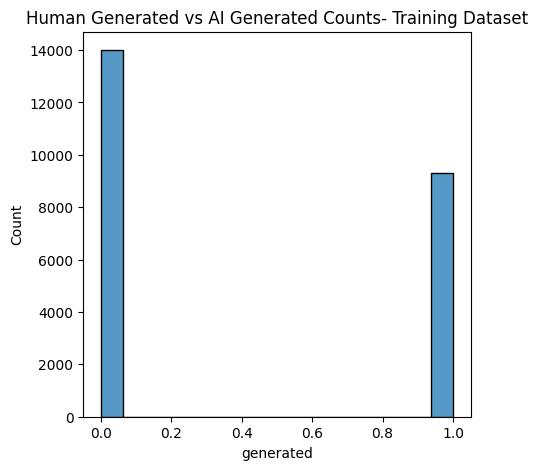

Imbalance:  1.5033283229546919


In [12]:
## Clean data
print("train dimensions: ", X_train.shape)
print("test dimensions: ", X_test.shape)

#Checking for null values and duplicates
print("\nTrain null values?: ",X_train.isnull().values.any())
print("Test null values?: ",X_test.isnull().values.any())
X_train.drop_duplicates()
X_test.drop_duplicates()
print("train dimensions: ", X_train.shape)
print("test dimensions: ", X_test.shape)

# counts plot
print()

plt.figure(figsize = (5,5))
sns.histplot(y_train)
plt.title("Human Generated vs AI Generated Counts- Training Dataset")
plt.show()

#calculate imbalance ratio
num_zeros = (y_train== 0).sum()
num_ones = (y_train == 1).sum()
imbalance = num_zeros/num_ones
print("Imbalance: ", imbalance)      

In [13]:
# since the human generated count was higher than the AI count I rebalance the train dataset to have equal proportions
rus = RandomUnderSampler(random_state=0, sampling_strategy = 'majority')
X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)

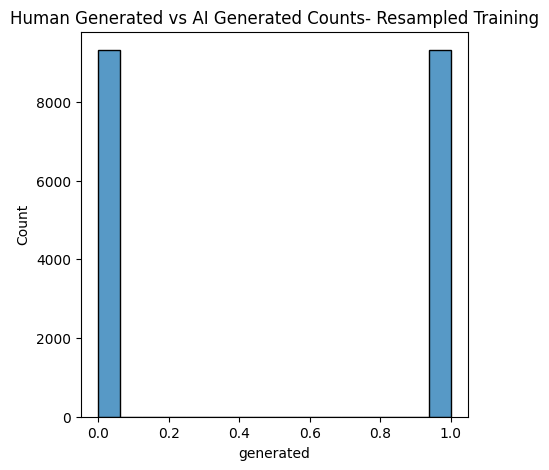

Imbalance:  1.0
train new dimensions:  (18628, 1)
9314.0
2914.5


In [14]:
#new counts plot
plt.figure(figsize = (5,5))
sns.histplot(y_X_resampled)
plt.title("Human Generated vs AI Generated Counts- Resampled Training")
plt.show()
#calculate imbalance ratio
num_zeros = (y_X_resampled== 0).sum()
num_ones = (y_X_resampled == 1).sum()

imbalance = num_zeros/num_ones
print("Imbalance: ", imbalance)

print("train new dimensions: ", X_resampled.shape)
print(len(y_X_resampled)/2)
print(len(y_test)/2)

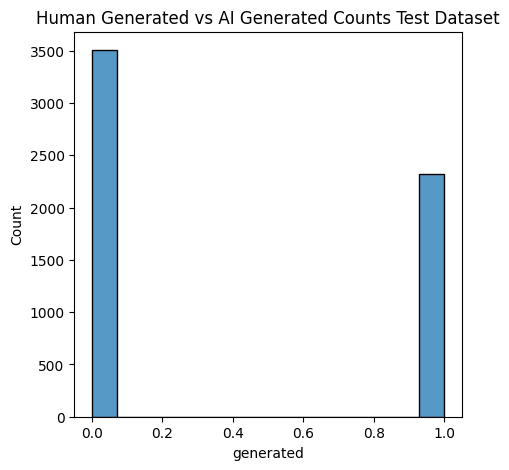

In [15]:
#test dataset counts
plt.figure(figsize = (5,5))
sns.histplot(y_test)
plt.title("Human Generated vs AI Generated Counts Test Dataset")
plt.show()

In [16]:
# Text Prepocessing Fxn
# I remove stop words and reduce words to roots stems
def preprocess_text(text):
  # Tokenization
  words = nltk.word_tokenize(text=text, language='english')

  # stop words removal
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # Stem
  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]
  return ' '.join(words)

# Preposses test to create a 'CleanText' column
X_resampled['CleanText'] = X_resampled['text'].apply(preprocess_text)
X_test['CleanText'] = X_test['text'].apply(preprocess_text)

print(X_resampled.head())

                                                    text   
4361   We use them everyday, they get us to our desti...  \
17502  I don't think our school needs to follow this ...   
12967  Dear State Senator,\n\nI feel as if we should ...   
28076  Now a days you see everyone with cars driving ...   
8386   Everybody may be have different opinion for ev...   

                                               CleanText  
4361   we use everyday , get us destin , would life w...  
17502  i n't think school need follow model extend sc...  
12967  dear state senat , i feel say vote presid ... ...  
28076  now day see everyon car drive place instead wa...  
8386   everybodi may differ opinion everyth , includ ...  


In [17]:
#TFIDF 
#common English words, words occurring in
# only one document or in at least 95% of the documents are removed.
      
#0.95
tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.95,
                            min_df=round(len(X_resampled)*0.01),
                            stop_words="english")

tfidf_vect.fit(X_resampled["CleanText"])
tfidf_train = tfidf_vect.transform(X_resampled["CleanText"])
tfidf_test = tfidf_vect.transform(X_test['CleanText'])
print(tfidf_train.shape)
print(tfidf_test.shape)


(18628, 1746)
(5829, 1746)


In [18]:
###Embed Data

#Embedding for train
embedding = umap.UMAP(n_components=2).fit_transform(tfidf_train)
#Embedding for test
embedding_test =  umap.UMAP(n_components=2).fit_transform(tfidf_test)



### Exploratory Data Analysis

Initially, I viewed the text lengths distributions. 

In my inital model analysis I was unable to get high accuracy on any type of unsupervised model. I added dimensionality visualization to my exploratory data analysis to gain more knowledge about the data. There were several different essay types or prompts within the dataset this can be seen as clustering on the graphs below. The clustered nature of the data made me change my approach. Using the embedded data, I broke the data up by cluster. I created an elbow chart and based on this I decided to model with nine clusters. 

I then created unsupervised models for each individual cluster in order to more accurately predict AI generated text.

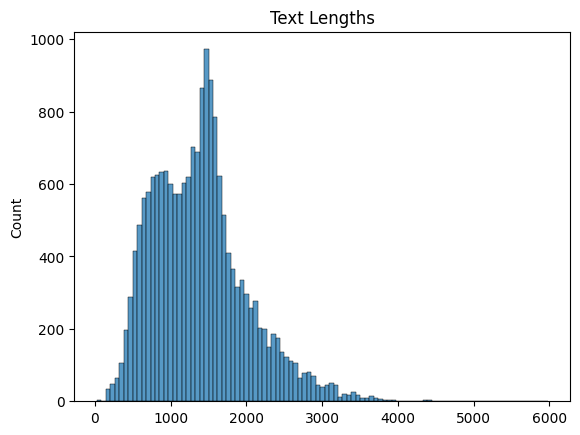

In [19]:
text_lengths = []
for i in X_resampled["CleanText"]:
    text_lengths.append(len(i))
    
sns.histplot(text_lengths)
plt.title("Text Lengths")
plt.show()


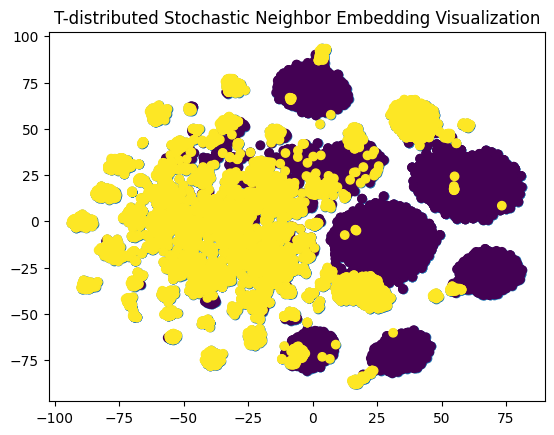

In [20]:
#TSNE Visualization of the TFIDF data

tsne = TSNE(n_components=2, init= 'random',random_state=42)
tsne_train = tsne.fit_transform(tfidf_train)

plt.scatter(tsne_train[:, 0], tsne_train[:, 1])

plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=y_X_resampled.astype('category').cat.codes, cmap='viridis')
plt.title("T-distributed Stochastic Neighbor Embedding Visualization")
plt.show()

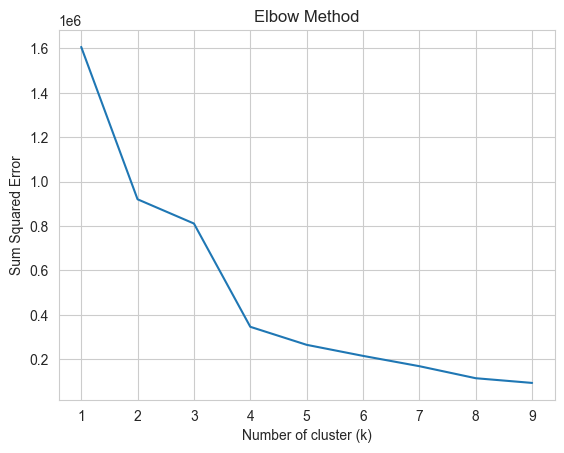

In [21]:
#Find optimum number of cluster
sse = [] 
for k in range(1,10):
    cl = KMeans(n_clusters=k)
    #cl = KMeans(n_clusters=k, random_state=2)
    cl.fit(embedding)
    sse.append(cl.inertia_)
    
sns.set_style("whitegrid")
graph=sns.lineplot(x=range(1,10), y=sse)

graph.set(xlabel ="Number of cluster (k)", 
      ylabel = "Sum Squared Error", 
      title ='Elbow Method')

plt.show()    

In [22]:
#Clustering the embedding data

#Determining clusters
cl_m = KMeans(9)
cl_m.fit(embedding)
#dist = cl.transform(embedding).min(1)

clusters = cl_m.predict(embedding)
clusters_test = cl_m.predict(embedding_test)


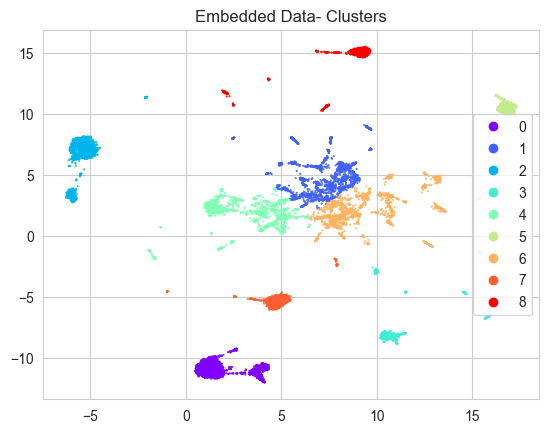

In [23]:
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=1, cmap='rainbow', c=clusters)
plt.title("Embedded Data- Clusters")
plt.legend(*scatter.legend_elements())

Text(0.5, 1.0, 'Embedded Data- Showing Human Generated (blue) vs AI (orange)')

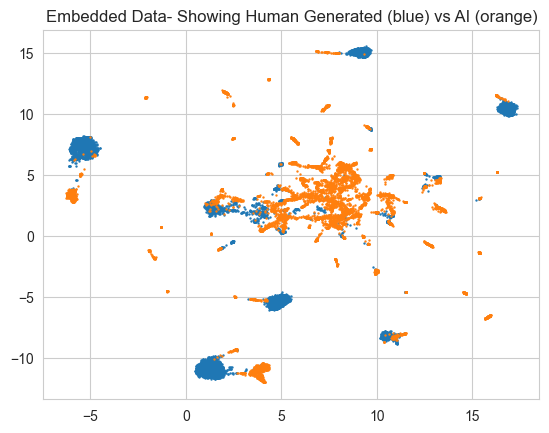

In [24]:
plt.scatter(embedding[:X_resampled.shape[0]][y_X_resampled == 0 , 0], embedding[:X_resampled.shape[0]][y_X_resampled == 0, 1], marker='.', s=2)
plt.scatter(embedding[:X_resampled.shape[0]][y_X_resampled == 1 , 0], embedding[:X_resampled.shape[0]][y_X_resampled == 1, 1], marker='.', s=2)
plt.title("Embedded Data- Showing Human Generated (blue) vs AI (orange)")

In [25]:
# trying with tdif

cl_tfidf = KMeans(9)

cl_tfidf .fit(tfidf_train)
dist_tfidf = cl_tfidf.transform(tfidf_train)
clusters_tfidf = cl_tfidf.predict(tfidf_train)
clusters_tfidf_test = cl_tfidf.predict(tfidf_test)


In [26]:
print(type(tfidf_train))

<class 'scipy.sparse._csr.csr_matrix'>


### Modeling

Using the embedded train data and the clusters, I use the following algorithms to create models on training data:

**Unsupervised**

- One Class Support Vector Machine 
- Non- Negative Matrix Factorization

**Supervised**

- Logistic Regression
- Linear SVC

I then apply the trained model to test data for predictions. 

In [27]:
###Create df of embedding, cluster, generated

y = pd.DataFrame({'generated':y_X_resampled})

emb = pd.DataFrame({'Embed_X':embedding[:, 0], 'Embed_Y':embedding[:, 1],'Cluster':clusters})
emb.insert(3,'y', list(y_X_resampled))
emb.index = list(y_X_resampled.index)

print(emb.shape)


### do same for test data
emb_test = pd.DataFrame({'Embed_X':embedding_test[:, 0], 'Embed_Y':embedding_test[:, 1],'Cluster':clusters_test})
emb_test.insert(3,'y', list(y_test))
emb_test.index = list(y_test.index)

print(emb_test)

(18628, 4)
         Embed_X   Embed_Y  Cluster  y
289     5.003548 -1.782068        7  1
6371   11.186631 -0.230351        6  0
27960  11.632978  5.550086        6  0
27362   4.671369  1.843039        4  1
23993   2.703073  2.398073        4  1
...          ...       ...      ... ..
18120   5.812968  3.345375        1  0
20256   5.092535  2.771825        4  1
20244   7.047047  1.716627        6  1
18974   5.823035  1.556731        4  1
1806   11.710560  5.247769        6  0

[5829 rows x 4 columns]


In [44]:
acc_chart_test = []
acc_chart_train = []

In [45]:
##############
## SVM Model
##############

#Here I create a SVM model by cluster, predict whether its AI generated, and check accuracy

dist_cluster = np.unique(emb.Cluster)
clf_svm =  OneClassSVM(kernel="rbf", degree=3, gamma=0.1, nu=0.01)
acc = []

for i in dist_cluster:
    subset = emb.loc[emb.Cluster == i, ["Embed_X","Embed_Y"]]
    y = emb.loc[emb.Cluster == i, "y"]
    clf_svm =  clf_svm.fit(subset)
    y_pred = clf_svm.predict(subset)
    svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
    label_map, accuracy = label_permute_compare(y, svm_predict) 
    print(f"Accuracy in separating Outlier for Topic {i}:", accuracy)
    if accuracy > 0:
        acc.append(accuracy)
  
print("Average train accuracy: ", sum(acc)/len(acc))   

# Using test dataset
dist_cluster = np.unique(emb_test.Cluster)

acc_test = []

for i in dist_cluster:
    subset = emb_test.loc[emb_test.Cluster == i, ["Embed_X","Embed_Y"]]
    y = emb_test.loc[emb_test.Cluster == i, "y"]
    clf_svm =  clf_svm.fit(subset)
    y_pred = clf_svm.predict(subset)
    svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
    label_map, accuracy = label_permute_compare(y, svm_predict)
    print(f"Test dataset Accuracy in separating Outlier for Cluster {i}:", accuracy)
    if accuracy > 0:
        acc_test.append(accuracy)
    
print("\nAverage test accuracy: ", sum(acc_test)/(len(acc_test))) 


Accuracy in separating Outlier for Topic 0: 0.7425864909390445
Accuracy in separating Outlier for Topic 1: 0.9308043554618897
Accuracy in separating Outlier for Topic 2: 0.7221526908635795
Accuracy in separating Outlier for Topic 3: 0.5085536547433903
Accuracy in separating Outlier for Topic 4: 0.5589614136314461
Accuracy in separating Outlier for Topic 5: 0.9508804448563485
Accuracy in separating Outlier for Topic 6: 0.8630933161123668
Accuracy in separating Outlier for Topic 7: 0.8589364844903988
Accuracy in separating Outlier for Topic 8: 0.6291148500365764
Average train accuracy:  0.7516759667927823
Test dataset Accuracy in separating Outlier for Cluster 1: 0.7134670487106017
Test dataset Accuracy in separating Outlier for Cluster 2: 0
Test dataset Accuracy in separating Outlier for Cluster 4: 0.6201222378937471
Test dataset Accuracy in separating Outlier for Cluster 6: 0.7714561234329798
Test dataset Accuracy in separating Outlier for Cluster 7: 0.6363636363636364

Average test ac

In [46]:
############################
### Hyperparameter tuning
############################
kernel = ["linear", "poly", "rbf", "sigmoid"]

best_acc = 0

for k in kernel:
    clf_svm = OneClassSVM(kernel=k, degree=3, gamma=0.1, nu=0.01)
    acc = []
    for i in dist_cluster:
        subset = emb.loc[emb.Cluster == i, ["Embed_X","Embed_Y"]]
        y = emb.loc[emb.Cluster == i, "y"]
        clf_svm =  clf_svm.fit(subset)
        y_pred = clf_svm.predict(subset)
        svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
        label_map, accuracy = label_permute_compare(y, svm_predict) 
        if accuracy > 0:
            acc.append(accuracy)
        
    accuracy =  sum(acc)/len(acc)
        
    if accuracy > best_acc:
        best_acc = accuracy
        best_kern = k
  
print("Best Kernel: ", best_kern)   
print("Accuracy: ", best_acc)   

gamma = [0.001, 0.01, 0.1, 1, 10]
best_acc = 0

for g in gamma:
    clf_svm = OneClassSVM(kernel=best_kern, degree=3, gamma=g, nu=0.01)
    acc = []
    for i in dist_cluster:
        subset = emb.loc[emb.Cluster == i, ["Embed_X","Embed_Y"]]
        y = emb.loc[emb.Cluster == i, "y"]
        clf_svm =  clf_svm.fit(subset)
        y_pred = clf_svm.predict(subset)
        svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
        label_map, accuracy = label_permute_compare(y, svm_predict) 
        if accuracy > 0:
            acc.append(accuracy)
        
    accuracy =  sum(acc)/len(acc)
    
    if accuracy > best_acc:
        best_acc = accuracy
        best_gamma = g
        
print("Best Gamma: ", best_gamma)   
print("Accuracy: ", best_acc)    

nu = [0.001, 0.01, 0.5]
best_acc = 0

for n in nu:
    clf_svm = OneClassSVM(kernel=best_kern, degree=3, gamma=best_gamma, nu=n)
    acc = []
    for i in dist_cluster:
        subset = emb.loc[emb.Cluster == i, ["Embed_X","Embed_Y"]]
        y = emb.loc[emb.Cluster == i, "y"]
        clf_svm =  clf_svm.fit(subset)
        y_pred = clf_svm.predict(subset)
        svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
        label_map, accuracy = label_permute_compare(y, svm_predict) 
        if accuracy > 0:
            acc.append(accuracy)
        
    accuracy =  sum(acc)/len(acc)
    
    if accuracy > best_acc:
        best_acc = accuracy
        best_nu = n
        
print("Best Nu: ", best_nu)   
print("Train Accuracy: ", best_acc)    
acc_chart_train.append(best_acc)

acc_test = []
clf_svm = OneClassSVM(kernel=best_kern, degree=3, gamma=best_gamma, nu=best_nu)



for i in dist_cluster:
    subset = emb_test.loc[emb_test.Cluster == i, ["Embed_X","Embed_Y"]]
    y = emb_test.loc[emb_test.Cluster == i, "y"]
    #confusion_y.extend(list(y))
    clf_svm =  clf_svm.fit(subset)
    y_pred = clf_svm.predict(subset)
    svm_predict = pd.Series(y_pred).replace([-1,1],[1,0])
    #confusion_pred.extend(list(svm_predict))
    label_map, accuracy = label_permute_compare(y, svm_predict)  
   # print(f"Accuracy in separating Outlier for cluster {i}:", accuracy)
    if accuracy > 0:
        acc_test.append(accuracy)
    
print("Best hyper parameter combo test accuracy: ", sum(acc_test)/(len(acc_test))) 

acc_chart_test.append(sum(acc_test)/(len(acc_test)))

Best Kernel:  linear
Accuracy:  0.8125038875199095
Best Gamma:  0.001
Accuracy:  0.8125038875199095
Best Nu:  0.01
Train Accuracy:  0.8125038875199095
Best hyper parameter combo test accuracy:  0.7579029341825655


In [47]:
##########################
## Kullback-Leibler model 
##########################
y_new = list(y_X_resampled)
dist_cluster_kl = np.unique(clusters_tfidf)
nmf_kl = NMF(2,solver = 'mu', beta_loss= 'kullback-leibler', l1_ratio= 0.25, random_state=0)
nmf_kl.fit(tfidf_train)

values = np.array(clusters_tfidf)
y_nmf_kl_predict = []
acc = []

for i in dist_cluster_kl:
    indexes = np.where(values == i)[0]
    subset = tfidf_train[indexes]
    y_sub = pd.array(y_new)[indexes]    
    y_pred = np.array([np.argmax(i) for i in nmf_kl.transform(subset)])
    #y_pred = nmf_kl.transform(subset)
    label_map, accuracy = label_permute_compare(list(y_sub), y_pred)  
    print(f"KL Accuracy in separating Outlier for cluster {i}:", accuracy)
    if accuracy > 0:
        acc.append(accuracy)
    
    
print("\nAverage train accuracy for Kullback-Leibler model: ", sum(acc)/len(acc))     
acc_chart_train.append(sum(acc)/len(acc))
#Kullback-Leibler model test dataset

clusters_tfidf_test
y_new = list(y_test)
dist_cluster_kl = np.unique(clusters_tfidf_test)


values = np.array(clusters_tfidf_test)
y_nmf_kl_predict = []
acc_test = []

for i in dist_cluster_kl:
    indexes = np.where(values == i)[0]
    subset = tfidf_test[indexes]
    y_sub = pd.array(y_new)[indexes]     
    y_pred = np.array([np.argmax(i) for i in nmf_kl.transform(subset)])
    label_map, accuracy = label_permute_compare(list(y_sub), y_pred)  
    print(f"KL Accuracy in separating Outlier for Topic {i}:", accuracy)
    if accuracy > 0:
        acc_test.append(accuracy)
    
    
print("\nAverage test accuracy for Kullback-Leibler model: ", sum(acc_test)/len(acc_test))     
acc_chart_test.append(sum(acc_test)/len(acc_test))
    

KL Accuracy in separating Outlier for cluster 0: 1.0
KL Accuracy in separating Outlier for cluster 1: 0.8468045112781954
KL Accuracy in separating Outlier for cluster 2: 0.719916142557652
KL Accuracy in separating Outlier for cluster 3: 0.8450331125827815
KL Accuracy in separating Outlier for cluster 4: 0.8464087090285173
KL Accuracy in separating Outlier for cluster 5: 0.9147909967845659
KL Accuracy in separating Outlier for cluster 6: 0.6750848096494535
KL Accuracy in separating Outlier for cluster 7: 0.8180272108843537
KL Accuracy in separating Outlier for cluster 8: 0.8825363825363826

Average train accuracy for Kullback-Leibler model:  0.8387335417002113
KL Accuracy in separating Outlier for Topic 0: 1.0
KL Accuracy in separating Outlier for Topic 1: 0.8652849740932642
KL Accuracy in separating Outlier for Topic 2: 0.8067226890756303
KL Accuracy in separating Outlier for Topic 3: 0.8951310861423221
KL Accuracy in separating Outlier for Topic 4: 0.787598944591029
KL Accuracy in sep

Accuracy: 0.9671999141077947, C: 0.01
Accuracy: 0.9804595232982607, C: 0.1
Accuracy: 0.9888340133132918, C: 1
Accuracy: 0.9973695512132273, C: 10
Accuracy: 0.9995705389735882, C: 100
Logistic Regressio Train Best accuracy: 0.9995705389735882, Best C: 100


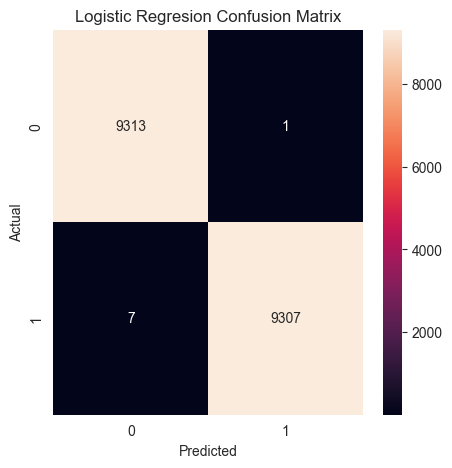

Logistic Regression Model Test Accuracy:  0.9917653113741637


In [48]:
##########################
## Logistic Regression
##########################

best_acc = 0
best_C = 0
#y_train = y_train


C_list = [0.01, 0.1, 1, 10, 100]
# Loopover the C values
for C in C_list:
    # Create a logistic regression model with the current C
    model = LogisticRegression(C=C)
    # Fit the model on the train set
    model.fit(tfidf_train, y_X_resampled)
    # Predict the labels on the validation set
    y_pred = model.predict(tfidf_train)
    # Compute the accuracy on the validation set
    acc = accuracy_score(y_X_resampled, y_pred)
    # Print the accuracy and the C value
    print(f"Accuracy: {acc}, C: {C}")
    # Update the best accuracy and the best C if needed
    if acc > best_acc:
        best_acc = acc
        best_C = C

# Print the best accuracy and the best C
print(f"Logistic Regressio Train Best accuracy: {best_acc}, Best C: {best_C}")
acc_chart_train.append(best_acc)

labels = np.unique(y_X_resampled)
conf_mat = confusion_matrix(y_X_resampled, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_X_resampled), yticklabels=np.unique(y_X_resampled))
plt.title("Logistic Regresion Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### using test 
#model = LogisticRegression(C=9)
#model.fit(tfidf_train, y_X_resampled)
y_pred = model.predict(tfidf_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Model Test Accuracy: ", acc)
acc_chart_test.append(acc)



Linear SVC Train Accuracy: 0.9979063774962422


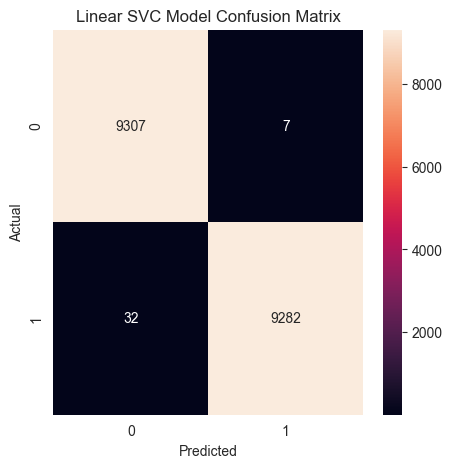

Linear SVC Model Test Accuracy:  0.9921084234002402


In [49]:
##########################
## Linear SVC
##########################

lsvc= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

lsvc.fit(tfidf_train, y_X_resampled)
y_pred = lsvc.predict(tfidf_train)
lsvc_acc = accuracy_score(y_X_resampled, y_pred)
print("Linear SVC Train Accuracy:", lsvc_acc)
acc_chart_train.append(acc)

labels = np.unique(y_X_resampled)
conf_mat = confusion_matrix(y_X_resampled, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_X_resampled), yticklabels=np.unique(y_X_resampled))
plt.title("Linear SVC Model Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
##### test
y_pred = lsvc.predict(tfidf_test)

acc = accuracy_score(y_test, y_pred)
print("Linear SVC Model Test Accuracy: ", acc)
acc_chart_test.append(acc)

In [38]:
# this is my label_permute_compare function from week 4
# it finds the appropriate labeling of the unsupervised model and returns the accuracy

def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc


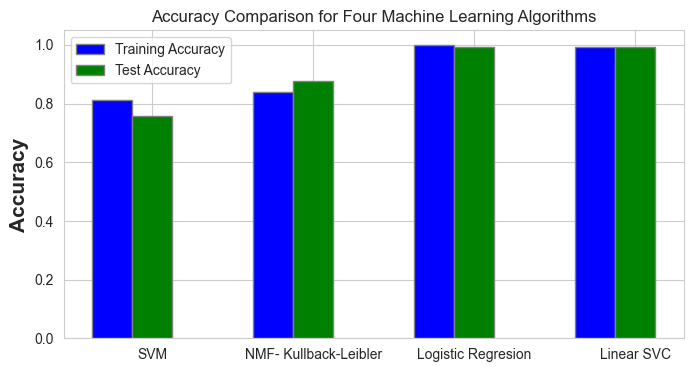

In [50]:
#############################
# Create Bar Chart for Accuracy Comparison
#############################

# Store Metrics from 3 models for test and train
#print(acc_chart_train)
#print(acc_chart_test)

algo = ['SVM', 'NMF- Kullback-Leibler','Logistic Regresion','Linear SVC']
# Create Bar Chart for MSE
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(8, 4)) 

# Set position of bar on X axis 
br1 = np.arange(len(acc_chart_train)) 
br2 = [x + barWidth for x in br1] 

# Make the plot
print()
print()
plt.bar(br1, acc_chart_train, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training Accuracy') 
plt.bar(br2, acc_chart_test, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Test Accuracy') 

# Adding Labels 
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(acc_chart_test))],algo)
plt.title("Accuracy Comparison for Four Machine Learning Algorithms")
plt.legend()
plt.show() 


### Conclusion

In this project I tested the performance of two unsupervised learning algorithms in the detection of AI generated text. I then compared them to supervised learning approaches. The accuracy results for all four models are summarized in the following table. The non-negative matrix factorization using the Kullback-Leibler divergence method performed decently well as an unsupervised model to detect AI generated text, although it did have a longer execution time than the other models. The supervised models both performed very well. However, it is more likely that in a real-life scenario training labels would not be available for generated text; thus, unsupervised or more advanced approaches would be more practical. As the use of LLM and AI generated content becomes more ubiquitous, it will become increasingly important to be able to separate AI generated content from human generated content.         


|Method|Accuracy||
|:----|:--------:|:------:|
||Train|Test|
|**Unsupervised**|||
|SVM | 0.8125 |0.7579|
|NMF- Kullback-Leibler| 0.8387 |0.8758|
|**Supervised**|||
|Logistic Regression| 0.9996 |0.9921|
|Linear SVC| 0.9979|0.9921|

### References


Document embedding using UMAP — umap 0.5 documentation. (2018). Readthedocs.io. https://umap-learn.readthedocs.io/en/latest/document_embedding.html Accessed 14 Sept 2024.

Klingensmith, K. (2023, January 23). K-means Clustering: An Introductory Guide and Practical Application. Medium. https://towardsdatascience.com/k-means-clustering-an-introductory-guide-and-practical-application-dce70bfa4249 Accessed 10 Sept 2024.


GeeksforGeeks. (2024, July 3). UMAP: Uniform Manifold Approximation and Projection. GeeksforGeeks; GeeksforGeeks. https://www.geeksforgeeks.org/umap-uniform-manifold-approximation-and-projection/ Accessed 14 Sept 2024.


Understanding One-Class Support Vector Machines. (2024, February 6). GeeksforGeeks. https://www.geeksforgeeks.org/understanding-one-class-support-vector-machines/ Accessed 14 Sept 2024.
